In [1]:
import os

mfile_path = "/home/christopher.lee/C.Lee--2025-Summer-Internship-Materials/ACTIVSg2000.m"
print("📂 File exists:", os.path.isfile(mfile_path))


📂 File exists: True


In [2]:
import os

os.chdir("/home/christopher.lee/C.Lee--2025-Summer-Internship-Materials")
print("Current working directory:", os.getcwd())


Current working directory: /home/christopher.lee/C.Lee--2025-Summer-Internship-Materials


In [3]:
import pandapower as pp
from pandapower.converter import from_psse

raw_file_path = "ACTIVSg2000.RAW"
net = from_psse(raw_file_path, version=33)

print(f"✅ Loaded network with {len(net.bus)} buses and {len(net.line)} lines.")


ImportError: cannot import name 'from_psse' from 'pandapower.converter' (/home/christopher.lee/miniconda3/envs/pandapower-clean/lib/python3.9/site-packages/pandapower/converter/__init__.py)

In [4]:
# Paths assuming current working directory is /home/christopher.lee/C.Lee--2025-Summer-Internship-Materials
input_path = "ACTIVSg2000.m"
output_path = "modified_ACTIVSg2000.m"

# Read the original .m file
with open(input_path, 'r') as file:
    lines = file.readlines()

def fix_gencost_line(line):
    """
    Change '4' to '3' in the 4th field for generator cost lines starting with '2'.
    Generator cost lines look like:
    2 0 0 4 c3 c2 c1 c0
    """
    parts = line.split()
    if len(parts) > 3 and parts[0] == '2' and parts[3] == '4':
        parts[3] = '3'  # Change 4 to 3
        return "\t".join(parts) + "\n"
    return line

# Write the modified lines to a new file
with open(output_path, 'w') as file:
    for line in lines:
        file.write(fix_gencost_line(line))

print(f"✅ Modified file saved as '{output_path}'")


✅ Modified file saved as 'modified_ACTIVSg2000.m'


In [5]:
import pandapower as pp
from pandapower.converter import from_mpc

mfile_path = "modified_ACTIVSg2000.m"

net = from_mpc(mfile_path, f_hz=60)

print(f"✅ Loaded network with {len(net.bus)} buses and {len(net.line)} lines.")


✅ Loaded network with 2000 buses and 2359 lines.


/home/christopher.lee/miniconda3/envs/pandapower-clean/lib/python3.9/site-packages/pandapower/converter/pypower/from_ppc.py:334: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  branch_lookup.loc[is_trafo, "element"] = idx_trafo


In [6]:
import pandapower as pp

# Run baseline power flow
pp.runpp(net)

# Sanity check: see overall load, voltages, etc.
print(net.res_bus[['vm_pu']].describe())
print(net.res_line[['loading_percent']].describe())


             vm_pu
count  2000.000000
mean      1.008675
std       0.015732
min       0.968702
25%       0.998209
50%       1.006656
75%       1.019206
max       1.040000
       loading_percent
count      2359.000000
mean         33.517531
std          16.078409
min           0.000000
25%          20.657796
50%          33.280884
75%          46.209222
max          86.780072


In [7]:
import pandas as pd
import pandapower as pp
from tqdm import tqdm  # Progress bar

results = []

for line_idx in tqdm(net.line.index, desc="Running single-line contingencies"):
    try:
        # Outage: take one line out
        net.line.in_service.at[line_idx] = False

        # Run power flow
        pp.runpp(net)

        # Use maximum loading as risk score
        max_loading = net.res_line.loading_percent.max()
        results.append({
            "line": line_idx,
            "from_bus": net.line.from_bus.at[line_idx],
            "to_bus": net.line.to_bus.at[line_idx],
            "risk_score": max_loading
        })

    except:
        # Power flow didn't converge, treat as high-risk
        results.append({
            "line": line_idx,
            "from_bus": net.line.from_bus.at[line_idx],
            "to_bus": net.line.to_bus.at[line_idx],
            "risk_score": 999.0
        })

    finally:
        # Restore the line
        net.line.in_service.at[line_idx] = True

# Save and inspect
df_risk = pd.DataFrame(results)
df_risk["normalized_risk"] = (df_risk.risk_score - df_risk.risk_score.min()) / (df_risk.risk_score.max() - df_risk.risk_score.min())
df_risk = df_risk.sort_values("normalized_risk", ascending=False).reset_index(drop=True)

# Preview
df_risk.head(10)


Running single-line contingencies: 100%|████| 2359/2359 [03:15<00:00, 12.05it/s]


,line,from_bus,to_bus,risk_score,normalized_risk
0,351,4002,4039,126.769561,1.000000
1,499,4078,4156,120.747820,0.862406
2,500,4078,4156,120.747820,0.862406
3,462,4054,4108,119.878895,0.842551
4,95,2002,2046,117.680727,0.792324
5,286,3128,3046,115.761233,0.748464
6,455,4126,4050,114.831499,0.727220
7,442,4087,4041,113.672590,0.700740
8,443,4087,4041,113.672590,0.700740
9,1627,6319,6311,113.026110,0.685968


In [8]:
# ✅ Save full ranked line risk scores to CSV
df_risk.to_csv("ACTIVSg2000_risk_scores.csv", index=False)
print("💾 Risk scores saved to ACTIVSg2000_risk_scores.csv")


💾 Risk scores saved to ACTIVSg2000_risk_scores.csv


In [9]:
net.bus.columns


Index(['name', 'vn_kv', 'type', 'zone', 'in_service', 'geo', 'max_vm_pu',
       'min_vm_pu'],
      dtype='object')

In [10]:
import re
import pandas as pd

aux_file_path = "ACTIVSg2000.aux"  # Or whichever file contains the block you posted

# Read the whole file
with open(aux_file_path, "r") as f:
    aux_text = f.read()

# Regex to extract Substation block data lines
pattern = r'\s+(\d+)\s+"([^"]+)"\s+"([^"]+)"\s+([-\d\.]+)\s+([-\d\.]+)'

matches = re.findall(pattern, aux_text)

# Create dataframe
substation_df = pd.DataFrame(matches, columns=["SubNum", "SubName", "SubID", "Latitude", "Longitude"])
substation_df["SubNum"] = substation_df["SubNum"].astype(int)
substation_df["Latitude"] = substation_df["Latitude"].astype(float)
substation_df["Longitude"] = substation_df["Longitude"].astype(float)

# Preview
print(substation_df.head())


   SubNum       SubName SubID   Latitude   Longitude
0       1      ODESSA 2     1  31.906736 -102.262348
1       2    PRESIDIO 2     2  29.888046 -104.519139
2       3   O DONNELL 1     3  32.926389 -101.647778
3       4  BIG SPRING 5     4  32.207500 -101.388333
4       5      VAN HORN     5  31.093480 -104.624514


In [11]:
print(net.bus.head())
print(net.bus.columns)


                name  vn_kv type zone  in_service   geo  max_vm_pu  min_vm_pu
1000      ODESSA 2 0  115.0    b  9.0        True  None        1.1        0.9
1001    PRESIDIO 2 0  115.0    b  9.0        True  None        1.1        0.9
1002   O DONNELL 1 0  115.0    b  9.0        True  None        1.1        0.9
1003   O DONNELL 1 1  230.0    b  9.0        True  None        1.1        0.9
1004  BIG SPRING 5 0  115.0    b  9.0        True  None        1.1        0.9
Index(['name', 'vn_kv', 'type', 'zone', 'in_service', 'geo', 'max_vm_pu',
       'min_vm_pu'],
      dtype='object')


In [12]:
import re
import pandas as pd

# Path to your AUX file
aux_path = "ACTIVSg2000.aux"

with open(aux_path, 'r') as file:
    aux_text = file.read()

# Use regex to extract the Substation block (between DATA(Substation, [...] ) { ... })
pattern = r"DATA\s*\(Substation,.*?\)\s*{(.*?)}"
match = re.search(pattern, aux_text, re.DOTALL | re.IGNORECASE)

if not match:
    raise ValueError("Substation block not found in AUX file")

substation_block = match.group(1).strip()

# Print a snippet to verify
print(substation_block[:500])  # print first 500 chars


1 "ODESSA 2" "1" 31.90673599999999870000 -102.26234800000000300000 ""     0.090000     0.090000
       2 "PRESIDIO 2" "2" 29.88804599999999920000 -104.51913899999999600000 ""     0.145000     0.145000
       3 "O DONNELL 1" "3" 32.92638900000000040000 -101.64777800000000200000 ""     0.111000     0.111000
       4 "BIG SPRING 5" "4" 32.20750000000000310000 -101.38833300000000300000 ""     0.290000     0.290000
       5 "VAN HORN" "5" 31.09347999999999960000 -104.62451400000000500000 ""     0.350


In [13]:
# Split into lines
lines = substation_block.splitlines()

# Prepare lists
sub_num = []
sub_name = []
sub_id = []
latitude = []
longitude = []

for line in lines:
    if not line.strip():
        continue  # skip empty lines
    parts = re.findall(r'("[^"]+"|\S+)', line)  # split by spaces but keep quoted strings intact
    # parts example: ['1', '"ODESSA 2"', '"1"', '31.906736', '-102.262348', '""', '0.090000', '0.090000']
    
    sub_num.append(int(parts[0]))
    sub_name.append(parts[1].strip('"'))
    sub_id.append(parts[2].strip('"'))
    latitude.append(float(parts[3]))
    longitude.append(float(parts[4]))

# Create DataFrame
subs_df = pd.DataFrame({
    'SubNum': sub_num,
    'SubName': sub_name,
    'SubID': sub_id,
    'Latitude': latitude,
    'Longitude': longitude
})

print(subs_df.head())
print(f"Loaded {len(subs_df)} substations.")


   SubNum       SubName SubID   Latitude   Longitude
0       1      ODESSA 2     1  31.906736 -102.262348
1       2    PRESIDIO 2     2  29.888046 -104.519139
2       3   O DONNELL 1     3  32.926389 -101.647778
3       4  BIG SPRING 5     4  32.207500 -101.388333
4       5      VAN HORN     5  31.093480 -104.624514
Loaded 1250 substations.


In [14]:
bus_df = net.bus.copy()  # or however you have your pandapower bus DataFrame
print(bus_df[['name']].head())


                name
1000      ODESSA 2 0
1001    PRESIDIO 2 0
1002   O DONNELL 1 0
1003   O DONNELL 1 1
1004  BIG SPRING 5 0


In [15]:
# Merge on name == SubName
bus_coords = bus_df.merge(subs_df, left_on='name', right_on='SubName', how='left')

# Check for any buses without coordinates
missing_coords = bus_coords[bus_coords['Latitude'].isnull()]
if not missing_coords.empty:
    print(f"Warning: {len(missing_coords)} buses have no matching substation coordinates!")
    print(missing_coords[['name']])

# Inspect the merged DataFrame
print(bus_coords[['name', 'Latitude', 'Longitude']].head())


                name
0         ODESSA 2 0
1       PRESIDIO 2 0
2      O DONNELL 1 0
3      O DONNELL 1 1
4     BIG SPRING 5 0
...              ...
1995       BREMOND 1
1996       BREMOND 2
1997       BRYAN 1 0
1998       BRYAN 1 1
1999       BRYAN 1 2

[2000 rows x 1 columns]
             name  Latitude  Longitude
0      ODESSA 2 0       NaN        NaN
1    PRESIDIO 2 0       NaN        NaN
2   O DONNELL 1 0       NaN        NaN
3   O DONNELL 1 1       NaN        NaN
4  BIG SPRING 5 0       NaN        NaN


In [16]:
net.bus['Latitude'] = bus_coords['Latitude'].values
net.bus['Longitude'] = bus_coords['Longitude'].values

# You can now access lat/lon for buses via:
print(net.bus[['name', 'Latitude', 'Longitude']].head())


                name  Latitude  Longitude
1000      ODESSA 2 0       NaN        NaN
1001    PRESIDIO 2 0       NaN        NaN
1002   O DONNELL 1 0       NaN        NaN
1003   O DONNELL 1 1       NaN        NaN
1004  BIG SPRING 5 0       NaN        NaN


In [17]:
print("Pandapower bus names sample:")
print(bus_df['name'].unique()[:10])

print("\nSubstation names sample:")
print(subs_df['SubName'].unique()[:10])


Pandapower bus names sample:
['ODESSA 2 0' 'PRESIDIO 2 0' 'O DONNELL 1 0' 'O DONNELL 1 1'
 'BIG SPRING 5 0' 'BIG SPRING 5 1' 'VAN HORN 0' 'IRAAN 2 0' 'IRAAN 2 1'
 'PRESIDIO 1 0']

Substation names sample:
['ODESSA 2' 'PRESIDIO 2' 'O DONNELL 1' 'BIG SPRING 5' 'VAN HORN' 'IRAAN 2'
 'PRESIDIO 1' 'SANDERSON' 'MONAHANS 2' 'GRANDFALLS']


In [18]:
import re

# Function to strip trailing space + number (e.g. "ODESSA 2 0" -> "ODESSA 2")
def strip_suffix(name):
    return re.sub(r'\s\d+$', '', name)

bus_df['name_clean'] = bus_df['name'].apply(strip_suffix).str.strip().str.lower()
subs_df['SubName_clean'] = subs_df['SubName'].str.strip().str.lower()

# Merge on cleaned names
bus_coords = bus_df.merge(subs_df, left_on='name_clean', right_on='SubName_clean', how='left')

print(bus_coords[['name', 'SubName', 'Latitude', 'Longitude']].head(10))


             name       SubName   Latitude   Longitude
0      ODESSA 2 0      ODESSA 2  31.906736 -102.262348
1    PRESIDIO 2 0    PRESIDIO 2  29.888046 -104.519139
2   O DONNELL 1 0   O DONNELL 1  32.926389 -101.647778
3   O DONNELL 1 1   O DONNELL 1  32.926389 -101.647778
4  BIG SPRING 5 0  BIG SPRING 5  32.207500 -101.388333
5  BIG SPRING 5 1  BIG SPRING 5  32.207500 -101.388333
6      VAN HORN 0      VAN HORN  31.093480 -104.624514
7       IRAAN 2 0       IRAAN 2  30.931467 -102.201433
8       IRAAN 2 1       IRAAN 2  30.931467 -102.201433
9    PRESIDIO 1 0    PRESIDIO 1  29.600000 -104.300000


In [19]:
# If you already have the substation DataFrame in memory:
substation_df.to_csv("parsed_substations.csv", index=False)
print("✅ Saved substation coordinates to parsed_substations.csv")


✅ Saved substation coordinates to parsed_substations.csv


In [20]:
# Step 1: Clean column names to lowercase for easier merging
substation_df.columns = substation_df.columns.str.strip().str.lower()

# Step 2: Re-extract substation names from pandapower bus names
bus_df = net.bus.copy()
bus_df['substation_name'] = bus_df['name'].str.extract(r'^(.+?) \d+$')[0]

# Step 3: Merge coordinates from substation_df
merged_df = bus_df.merge(
    substation_df[['subname', 'latitude', 'longitude']],
    left_on='substation_name',
    right_on='subname',
    how='left'
)

# Step 4: Report how many matched
print(f"✅ {merged_df['latitude'].notna().sum()} / {len(merged_df)} buses matched with coordinates.")

# Step 5: Finalize buses_df for plotting
buses_df = merged_df[['name', 'latitude', 'longitude']].copy()
buses_df['bus'] = buses_df.index  # Retain bus index
print(buses_df.head())


✅ 1999 / 2000 buses matched with coordinates.
             name   latitude   longitude  bus
0      ODESSA 2 0  31.906736 -102.262348    0
1    PRESIDIO 2 0  29.888046 -104.519139    1
2   O DONNELL 1 0  32.926389 -101.647778    2
3   O DONNELL 1 1  32.926389 -101.647778    3
4  BIG SPRING 5 0  32.207500 -101.388333    4


In [21]:
import pandas as pd

risk_df = pd.read_csv("ACTIVSg2000_risk_scores.csv")
print(risk_df.head())


   line  from_bus  to_bus  risk_score  normalized_risk
0   351      4002    4039  126.769561         1.000000
1   499      4078    4156  120.747820         0.862406
2   500      4078    4156  120.747820         0.862406
3   462      4054    4108  119.878895         0.842551
4    95      2002    2046  117.680727         0.792324


In [28]:
import pandas as pd

# Extract line data from the pandapower network
line_df_raw = net.line.copy()

# Add line index as ID (if not already a column)
line_df_raw = line_df_raw.reset_index().rename(columns={'index': 'line'})

# Extract the bus connection info
line_df_raw = line_df_raw[['line', 'from_bus', 'to_bus']]


In [29]:
# Convert line column to same type to ensure merge works
line_df_raw['line'] = line_df_raw['line'].astype(int)
risk_df['line'] = risk_df['line'].astype(int)

# Merge risk scores into the line table
lines_df = line_df_raw.merge(risk_df[['line', 'risk_score', 'normalized_risk']], on='line', how='left')

# Fill missing risk values with 0 (optional)
lines_df['risk_score'] = lines_df['risk_score'].fillna(0)
lines_df['normalized_risk'] = lines_df['normalized_risk'].fillna(0)


In [30]:
# Merge from_bus coordinates
lines_df = lines_df.merge(
    buses_df[['bus', 'latitude', 'longitude']],
    left_on='from_bus', right_on='bus', how='left'
).rename(columns={'latitude': 'from_lat', 'longitude': 'from_lon'}).drop(columns='bus')

# Merge to_bus coordinates
lines_df = lines_df.merge(
    buses_df[['bus', 'latitude', 'longitude']],
    left_on='to_bus', right_on='bus', how='left'
).rename(columns={'latitude': 'to_lat', 'longitude': 'to_lon'}).drop(columns='bus')


In [31]:
print(lines_df.columns)
print(lines_df.head())
print(lines_df[['from_lat', 'from_lon', 'to_lat', 'to_lon']].isna().sum())


Index(['line', 'from_bus', 'to_bus', 'risk_score', 'normalized_risk',
       'from_lat', 'from_lon', 'to_lat', 'to_lon'],
      dtype='object')
   line  from_bus  to_bus  risk_score  normalized_risk   from_lat   from_lon  \
0     0      1000    1063   86.779408         0.086242  32.930338 -96.787496   
1     1      1000    1063   86.779408         0.086242  32.930338 -96.787496   
2     2      1000    1070   86.779383         0.086241  32.930338 -96.787496   
3     3      1000    1070   86.779383         0.086241  32.930338 -96.787496   
4     4      1001    1006   86.780064         0.086257  31.696619 -97.073707   

      to_lat     to_lon  
0  29.700745 -97.301328  
1  29.700745 -97.301328  
2  30.562551 -97.907897  
3  30.562551 -97.907897  
4  32.749099 -97.272957  
from_lat    2275
from_lon    2275
to_lat      2280
to_lon      2280
dtype: int64


/tmp/ipykernel_10787/2845250983.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("viridis")


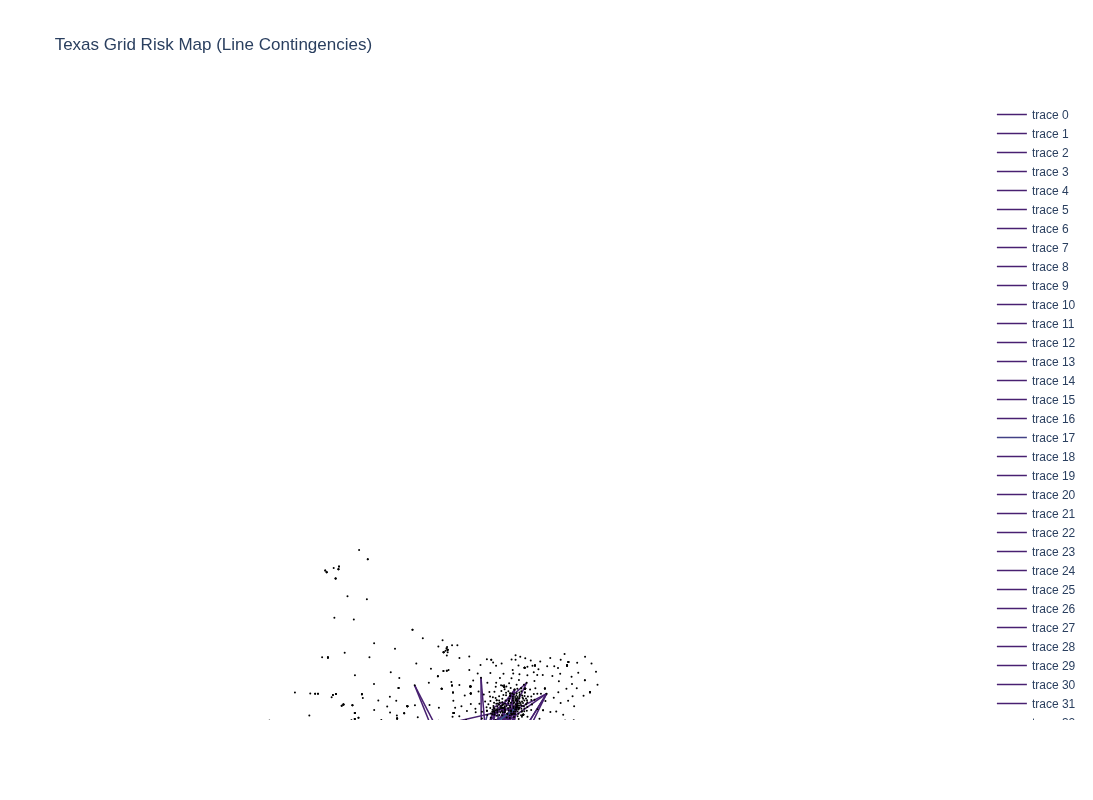

In [32]:
import plotly.graph_objects as go
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Normalize risk score for colormap
norm = mcolors.Normalize(vmin=lines_df['normalized_risk'].min(), vmax=lines_df['normalized_risk'].max())
colormap = cm.get_cmap("viridis")

# Convert normalized risk to RGBA hex
def risk_to_color(val):
    rgba = colormap(norm(val))
    return f'rgba({int(rgba[0]*255)}, {int(rgba[1]*255)}, {int(rgba[2]*255)}, {rgba[3]:.2f})'

lines_df['color'] = lines_df['normalized_risk'].apply(risk_to_color)

# Create line segments for each transmission line
line_segments = []
for _, row in lines_df.iterrows():
    if np.isnan(row.from_lat) or np.isnan(row.to_lat):
        continue  # Skip if coordinates are missing
    segment = go.Scattergeo(
        lon=[row.from_lon, row.to_lon],
        lat=[row.from_lat, row.to_lat],
        mode='lines',
        line=dict(width=1.5, color=row.color),
        hoverinfo='text',
        text=f"Line {row.line}<br>Risk: {row.risk_score:.2f}"
    )
    line_segments.append(segment)

# Optional: Plot buses as small black dots
bus_trace = go.Scattergeo(
    lon=buses_df['longitude'],
    lat=buses_df['latitude'],
    mode='markers',
    marker=dict(size=2, color='black'),
    hoverinfo='none'
)

# Layout: plain, centered on Texas
layout = go.Layout(
    title="Texas Grid Risk Map (Line Contingencies)",
    geo=dict(
        scope='usa',
        projection_type='albers usa',
        showland=True,
        landcolor="white",
        showcountries=False,
        showlakes=False,
        lataxis=dict(range=[25, 37]),
        lonaxis=dict(range=[-107, -93]),
        showframe=False,
        showcoastlines=False,
    ),
    height=800,
    width=900
)

# Final plot
fig = go.Figure(data=line_segments + [bus_trace], layout=layout)
fig.show()


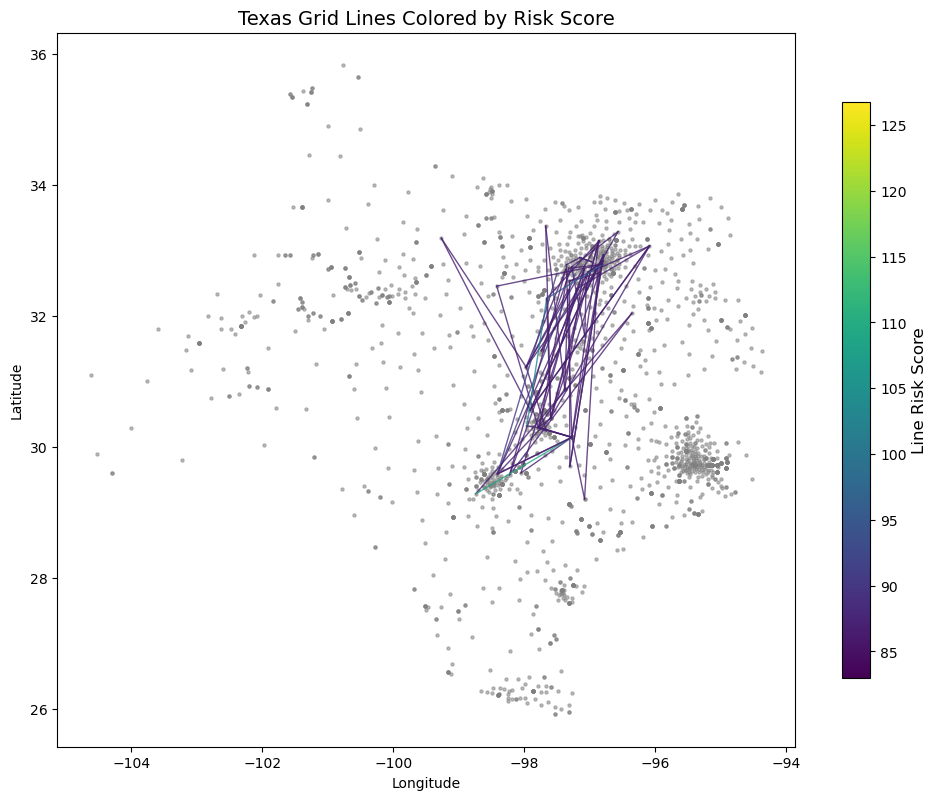

In [35]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Normalize risk scores to [0, 1] for colormap
norm = mcolors.Normalize(vmin=lines_df['risk_score'].min(), vmax=lines_df['risk_score'].max())

# Use updated colormap syntax for matplotlib ≥ 3.7
colormap = plt.colormaps.get_cmap("viridis")

fig, ax = plt.subplots(figsize=(10, 8))

# Plot each transmission line as a colored segment
for _, row in lines_df.iterrows():
    color = colormap(norm(row['risk_score']))
    ax.plot(
        [row['from_lon'], row['to_lon']],
        [row['from_lat'], row['to_lat']],
        color=color,
        linewidth=1,
        alpha=0.8
    )

# Plot all buses as small gray dots
ax.scatter(
    buses_df['longitude'], buses_df['latitude'],
    color='gray', s=5, alpha=0.5, label="Buses"
)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.8)
cbar.set_label('Line Risk Score', fontsize=12)

# Labels and layout
ax.set_title("Texas Grid Lines Colored by Risk Score", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect('equal', 'box')
plt.tight_layout()
plt.show()


In [36]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import pandas as pd

# STEP 1 — Get all lines in pandapower network
pp_lines_df = net.line.copy()
pp_lines_df["line"] = pp_lines_df.index  # Keep line IDs
pp_lines_df["from_bus"] = pp_lines_df["from_bus"].astype(int)
pp_lines_df["to_bus"] = pp_lines_df["to_bus"].astype(int)

# STEP 2 — Merge with risk scores
# If your risk_df contains line IDs and scores:
all_lines_df = pp_lines_df.merge(risk_df[["line", "risk_score"]], on="line", how="left")

# STEP 3 — Fill missing risk scores with 0 (or small value)
all_lines_df["risk_score"] = all_lines_df["risk_score"].fillna(0)

# STEP 4 — Merge geographic coordinates
all_lines_df = all_lines_df.merge(
    buses_df.rename(columns={"bus": "from_bus", "latitude": "from_lat", "longitude": "from_lon"}),
    on="from_bus", how="left"
)
all_lines_df = all_lines_df.merge(
    buses_df.rename(columns={"bus": "to_bus", "latitude": "to_lat", "longitude": "to_lon"}),
    on="to_bus", how="left"
)

# Drop any lines that are missing coordinates
all_lines_df = all_lines_df.dropna(subset=["from_lat", "from_lon", "to_lat", "to_lon"])


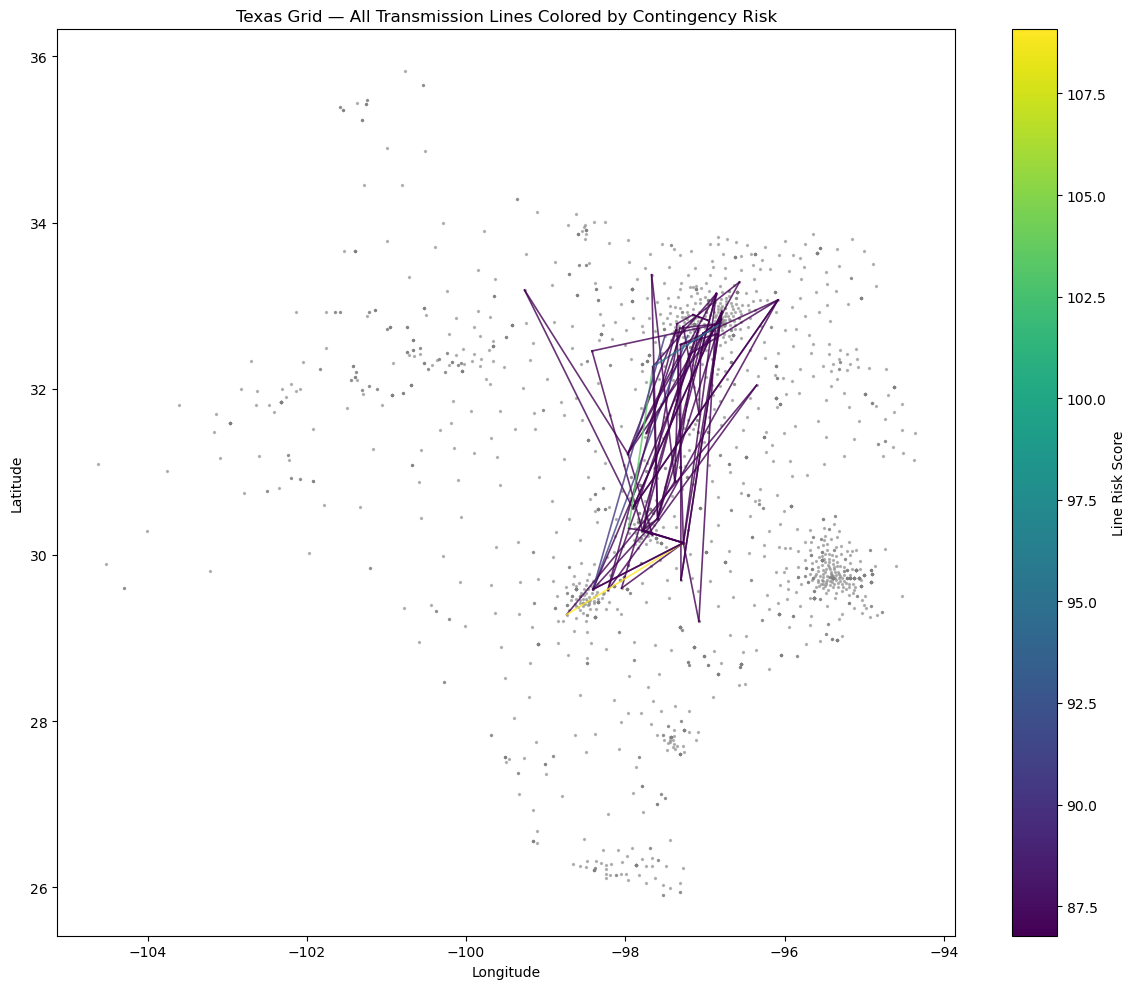

In [37]:
# Normalize color by risk score
norm = mcolors.Normalize(vmin=all_lines_df['risk_score'].min(), vmax=all_lines_df['risk_score'].max())
colormap = plt.get_cmap("viridis")

fig, ax = plt.subplots(figsize=(12, 10))

# Plot all lines with color
for _, row in all_lines_df.iterrows():
    ax.plot(
        [row['from_lon'], row['to_lon']],
        [row['from_lat'], row['to_lat']],
        color=colormap(norm(row['risk_score'])),
        linewidth=1.2,
        alpha=0.8
    )

# Plot all bus points in background
ax.scatter(buses_df["longitude"], buses_df["latitude"], s=2, color="gray", alpha=0.5)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Line Risk Score")

ax.set_title("Texas Grid — All Transmission Lines Colored by Contingency Risk")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()


In [38]:
# Example if you have a single line ID column
num_lines_in_risk_df = risk_df['line_id'].nunique()
print(f"Number of unique lines with risk scores: {num_lines_in_risk_df}")

# Or if lines are identified by from_bus and to_bus columns
num_lines_in_risk_df = risk_df[['from_bus', 'to_bus']].drop_duplicates().shape[0]
print(f"Number of unique lines with risk scores: {num_lines_in_risk_df}")


KeyError: 'line_id'

In [44]:
from_buses_in_buses = lines_df['from_bus'].isin(buses_df['bus'])
to_buses_in_buses = lines_df['to_bus'].isin(buses_df['bus'])

print(f"Lines with from_bus not in buses_df: {(~from_buses_in_buses).sum()}")
print(f"Lines with to_bus not in buses_df: {(~to_buses_in_buses).sum()}")


Lines with from_bus not in buses_df: 2275
Lines with to_bus not in buses_df: 2280


In [45]:
from_buses_missing = set(lines_df.loc[~from_buses_in_buses, 'from_bus'])
to_buses_missing = set(lines_df.loc[~to_buses_in_buses, 'to_bus'])

print(f"Sample missing from_bus IDs: {list(from_buses_missing)[:10]}")
print(f"Sample missing to_bus IDs: {list(to_buses_missing)[:10]}")


Sample missing from_bus IDs: [2048, 2049, 2050, 4098, 2052, 2053, 2054, 4099, 4101, 2057]
Sample missing to_bus IDs: [2048, 2049, 2050, 2051, 2052, 2053, 2054, 4098, 4099, 2057]


In [47]:
import re
import pandas as pd

# Load .aux file
with open("ACTIVSg2000.aux", "r") as f:
    aux_text = f.read()

# Match the Substation block
match = re.search(r"DATA\s*\(Substation.*?\)\s*\{(.*?)\}", aux_text, re.DOTALL)
if not match:
    raise ValueError("Could not find Substation block in AUX file")

# Parse lines
block = match.group(1)
lines = block.strip().splitlines()

# Extract fields: SubNum (ID), Name, ID, Latitude, Longitude
parsed = []
for line in lines:
    parts = re.findall(r'"[^"]*"|\S+', line.strip())
    if len(parts) >= 5:
        subnum = int(parts[0])
        lat = float(parts[3])
        lon = float(parts[4])
        parsed.append((subnum, lat, lon))

# Create dataframe
buses_df = pd.DataFrame(parsed, columns=["bus", "latitude", "longitude"])

print(f"Extracted {len(buses_df)} substations with coordinates")
print(buses_df.head())


Extracted 1250 substations with coordinates
   bus   latitude   longitude
0    1  31.906736 -102.262348
1    2  29.888046 -104.519139
2    3  32.926389 -101.647778
3    4  32.207500 -101.388333
4    5  31.093480 -104.624514


In [51]:
# Use substations as proxy for bus coordinates
lines_df = lines_df.merge(
    buses_df.rename(columns={"bus": "from_bus"}), on="from_bus", how="left"
).rename(columns={"latitude": "from_lat", "longitude": "from_lon"})

lines_df = lines_df.merge(
    buses_df.rename(columns={"bus": "to_bus"}), on="to_bus", how="left"
).rename(columns={"latitude": "to_lat", "longitude": "to_lon"})


In [52]:
# Ensure 'line' column is set up
lines_df = net.line.copy().reset_index().rename(columns={'index': 'line'})
lines_df["from_bus"] = lines_df["from_bus"].astype(int)
lines_df["to_bus"] = lines_df["to_bus"].astype(int)

# Merge in contingency risk scores
lines_df = lines_df.merge(risk_df[["line", "risk_score"]], on="line", how="left")
lines_df["risk_score"] = lines_df["risk_score"].fillna(0)

# Merge coordinates from your full buses_df
lines_df = lines_df.merge(
    buses_df.rename(columns={"bus": "from_bus"}), on="from_bus", how="left"
).rename(columns={"latitude": "from_lat", "longitude": "from_lon"})

lines_df = lines_df.merge(
    buses_df.rename(columns={"bus": "to_bus"}), on="to_bus", how="left"
).rename(columns={"latitude": "to_lat", "longitude": "to_lon"})

# Drop lines with missing coordinates
lines_df = lines_df.dropna(subset=["from_lat", "from_lon", "to_lat", "to_lon"])


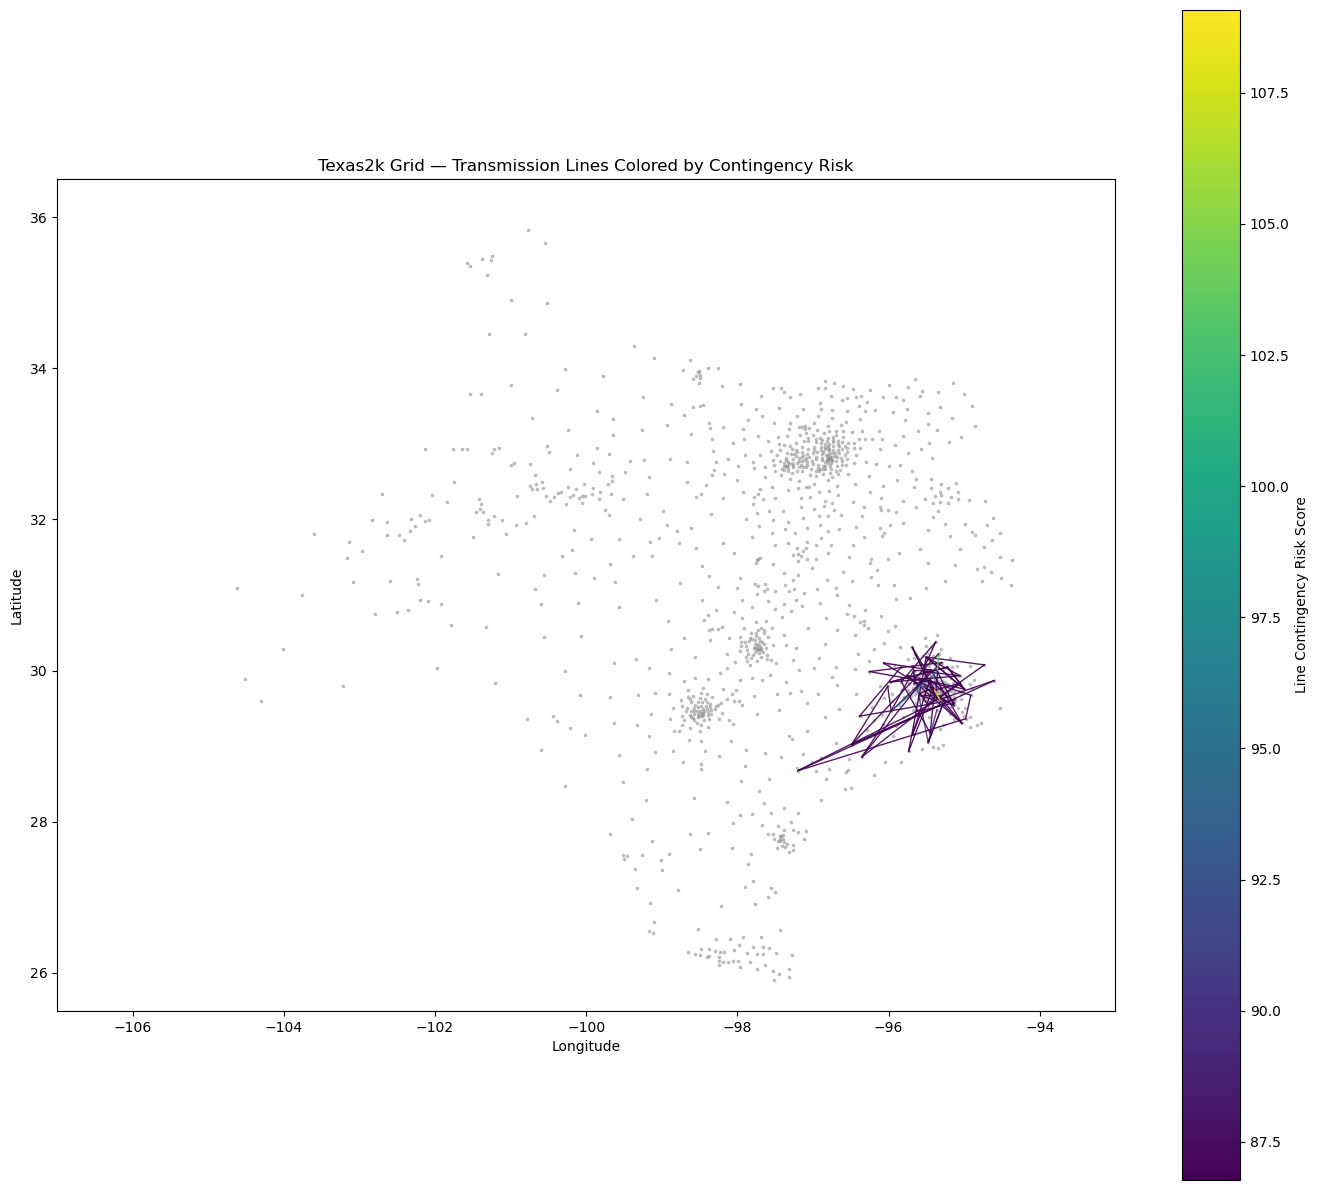

In [53]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Normalize color scale
norm = mcolors.Normalize(vmin=lines_df['risk_score'].min(), vmax=lines_df['risk_score'].max())
colormap = plt.get_cmap("viridis")

# Start figure
fig, ax = plt.subplots(figsize=(14, 12))

# Plot each line with risk-based color
for _, row in lines_df.iterrows():
    ax.plot(
        [row["from_lon"], row["to_lon"]],
        [row["from_lat"], row["to_lat"]],
        color=colormap(norm(row["risk_score"])),
        linewidth=1.0,
        alpha=0.9
    )

# Add all substations as gray dots
ax.scatter(buses_df["longitude"], buses_df["latitude"], s=3, color="gray", alpha=0.4)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Line Contingency Risk Score")

# Axis formatting
ax.set_title("Texas2k Grid — Transmission Lines Colored by Contingency Risk")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_xlim(-107, -93)   # Adjust bounds if needed
ax.set_ylim(25.5, 36.5)
ax.set_aspect("equal")
plt.tight_layout()
plt.show()


In [57]:
# Rank lines by risk score (higher risk → lower rank number)
lines_df["rank"] = lines_df["risk_score"].rank(method="min", ascending=False)

# Normalize ranks to [0, 1]
max_rank = lines_df["rank"].max()
lines_df["rank_norm"] = 1 - (lines_df["rank"] - 1) / (max_rank - 1)


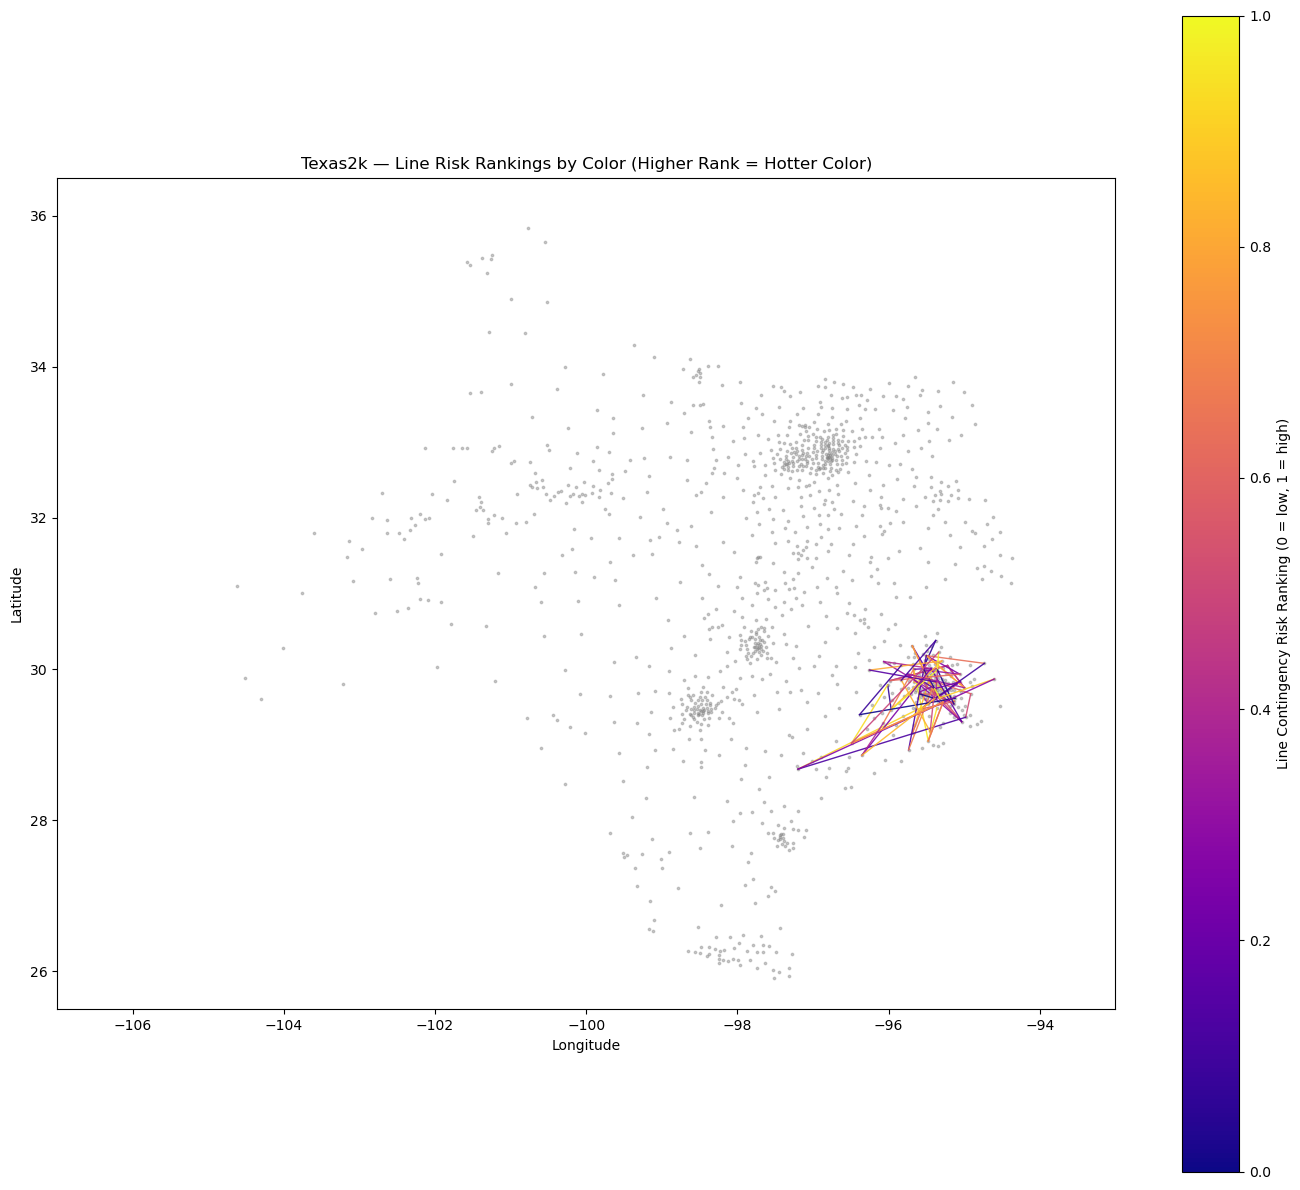

In [58]:
# Normalize rank from 0 to 1 (already done), so no need for norm()
colormap = plt.get_cmap("plasma")  # Try plasma or inferno for better range than viridis

fig, ax = plt.subplots(figsize=(14, 12))

for _, row in lines_df.iterrows():
    ax.plot(
        [row["from_lon"], row["to_lon"]],
        [row["from_lat"], row["to_lat"]],
        color=colormap(row["rank_norm"]),
        linewidth=1.0,
        alpha=0.9
    )

# Plot substations
ax.scatter(buses_df["longitude"], buses_df["latitude"], s=3, color="gray", alpha=0.4)

# Colorbar with label for rank
sm = plt.cm.ScalarMappable(cmap=colormap, norm=mcolors.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Line Contingency Risk Ranking (0 = low, 1 = high)")

ax.set_title("Texas2k — Line Risk Rankings by Color (Higher Rank = Hotter Color)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_xlim(-107, -93)
ax.set_ylim(25.5, 36.5)
ax.set_aspect("equal")
plt.tight_layout()
plt.show()


In [59]:
print(f"Total lines in net.line: {net.line.shape[0]}")
print(f"Lines in lines_df (after merges): {lines_df.shape[0]}")


Total lines in net.line: 2359
Lines in lines_df (after merges): 73


In [60]:
net_bus_ids = set(net.bus.index)
substation_ids = set(buses_df["bus"])

missing_in_coords = net_bus_ids - substation_ids
print(f"Sample net.bus IDs not found in buses_df: {list(missing_in_coords)[:10]}")
print(f"Total missing: {len(missing_in_coords)}")
print(f"Total in net.bus: {len(net_bus_ids)}, total in buses_df: {len(substation_ids)}")


Sample net.bus IDs not found in buses_df: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009]
Total missing: 1909
Total in net.bus: 2000, total in buses_df: 1250
